In [1]:
import torch
import os
import numpy as np
import sys
import time
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

sys.path.append("../")
from src.utils import load_processed_data, prepare_dataloaders
from src.model import GRUSurrogate, LSTMSurrogate, TCNForecaster

from plot_utils import plot_temperature_sequences

## 1. Load data and model

In [3]:
run_dir = "/home/obola/repositories/cicero-scm-surrogate/data/20250930_223742"
data_dir = os.path.join(run_dir, "processed")
device = "cuda:0"

# Load and format data
X_train, y_train, X_val, y_val, X_test, y_test = load_processed_data(data_dir)
train_loader, val_loader, test_loader, G, mu, std = prepare_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, 
                                                               batch_size=512, device=device, num_workers=2)

# Build model
#model = GRUSurrogate(n_gas=G).to(device)
model = LSTMSurrogate(n_gas=G, hidden=128, num_layers=1).to(device)
#model = TCNForecaster(n_gas=G, n_blocks=8, hidden=128, k=3).to(device)



model_dir = os.path.join(run_dir, "training_runs/20251001_104419_lstm_128_1/model.pth")
model.load_state_dict(torch.load(model_dir, map_location=device, weights_only=False))

<All keys matched successfully>

## 2. Run evaluation of model

In [4]:
y_pred_list, y_target_list = [], []
model.eval()
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        
        y_pred = model(xb).cpu().numpy()
        y_target = yb.cpu().numpy()
        
        # Save the data
        y_pred_list.append(y_pred)
        y_target_list.append(y_target)

y_pred_numpy = np.concatenate(y_pred_list)
y_target_numpy = np.concatenate(y_target_list)

rmse = np.sqrt(mean_squared_error(y_target_numpy, y_pred_numpy))
r2   = r2_score(y_target_numpy, y_pred_numpy)
print(f"RMSE: {rmse}, R2: {r2}")

RMSE: 0.00047153961922598157, R2: 0.9999987483024597


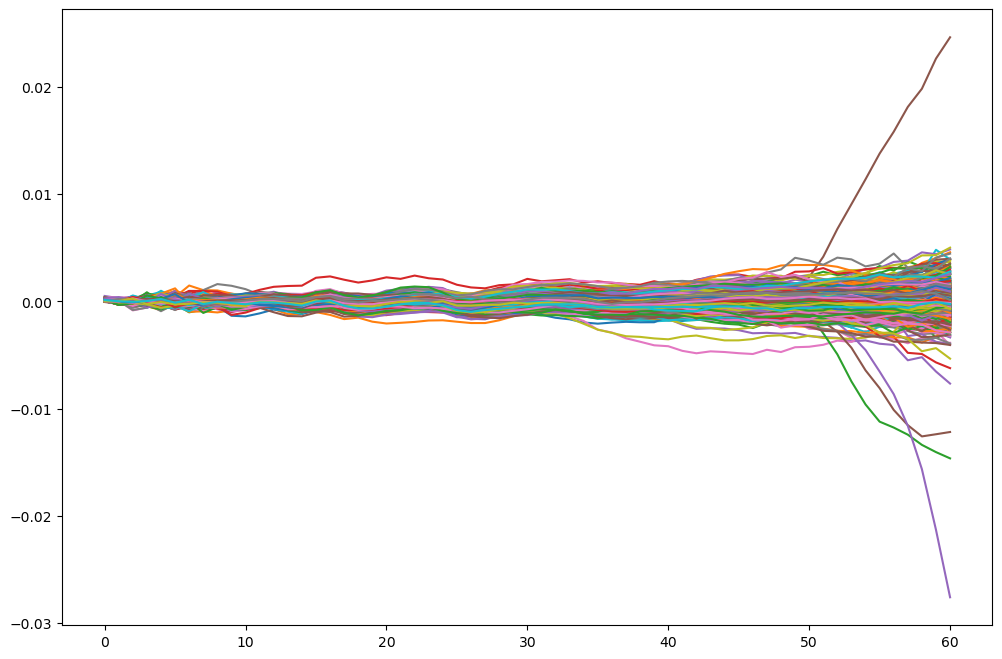

In [5]:
y_target_em_paths = y_target_numpy.reshape(-1, 61).T
y_pred_em_paths = y_pred_numpy.reshape(-1, 61).T

y_diff = y_target_em_paths - y_pred_em_paths

plt.figure(figsize=(12,8))
plt.plot(y_diff)
plt.show()

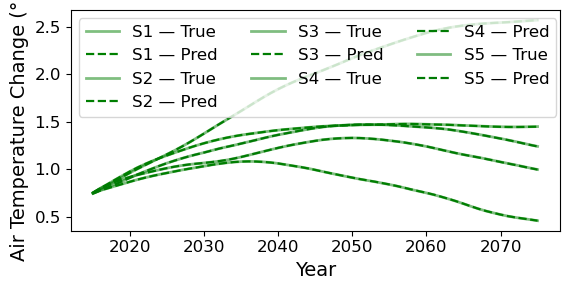

In [14]:
plot_temperature_sequences(y_target_numpy, y_pred_numpy, seq_len=61, n_samples=5, seed=29,
                   years=np.arange(2015, 2015+36+25), 
                   savepath="plots/test_seq_cicero_net.pdf")